In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

In [4]:
!pip install xrft --upgrade -q

# Dask start

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35643")

# Import

In [6]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe

# Plotting params

In [7]:
#%matplotlib widget
%matplotlib inline

In [8]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [9]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

# General functions for histograms

In [63]:
def compute_1D_histogram(dataSet, var1, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
    else :
        bins1 = bins
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), bins=bins1, weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [30]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [31]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

In [32]:
def fit_2D_histogram(hist_ds) :
    x_key = list(hist_ds.coords.keys())[0]
    y_key = list(hist_ds.coords.keys())[1]
    x=hist_ds[x_key]
    y=hist_ds[y_key]
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    x_vec = x_grid.flatten()
    y_vec = y_grid.flatten()
    weights = hist_ds.values.flatten()/np.sum(hist_ds.values)
    fitting_poly = P.polyfit(x_vec,y_vec,1,w=weights,full=True)
    slope = fitting_poly[0][1]
    increment = fitting_poly[0][0]
    resid = fitting_poly[1][0][0]
    mean_x = np.mean(x_grid*hist_ds.values)/np.sum(hist_ds.values)
    mean_y = np.mean(y_grid*hist_ds.values)/np.sum(hist_ds.values)
    return [slope, increment, resid, mean_x, mean_y]

In [33]:
nb_of_bins = 150

# Load data

Choose cases

In [10]:
data=[dict() for i in range(6)]

In [11]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

## eNATL60

In [12]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [13]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,250),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [14]:
nb_of_time_chunks = 4

In [15]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set
    data[i]['HR'].attrs['source'] = 'eNATL60'

CPU times: user 2.43 s, sys: 421 ms, total: 2.85 s
Wall time: 1min 25s


## eORCA025

In [16]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).rename(nav_lat='lat', nav_lon='lon')
    data[i]['LR'].attrs['source'] = 'eORCA025'

## Plot snapshots

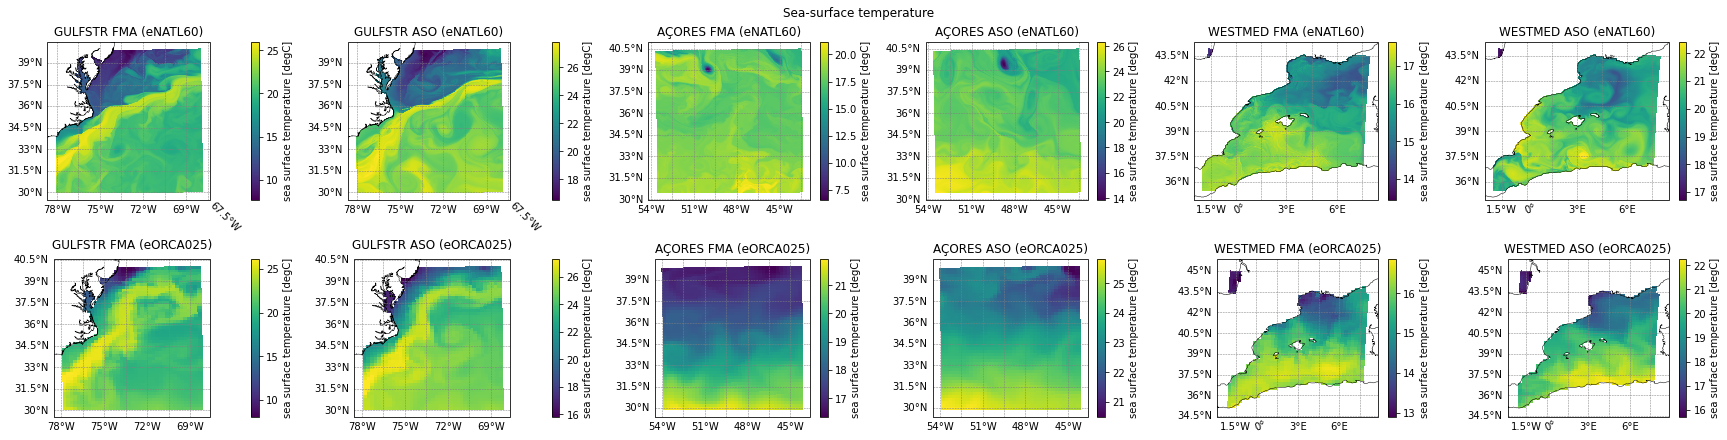

In [17]:
fig, axis = plt.subplots(ncols=len(data), nrows=2, figsize=(24,6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
fig.suptitle('Sea-surface temperature')
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR', 'LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=data[col]['label'] + ' ('+data[col][dataSetKey].attrs['source']+')')

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# "True" density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [18]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR', 'LR'] :
        # conservative temperature
        data[i][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['CT'], dask='parallelized').compute()
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['CT_sqr'] = data[i][dataKey]['CT']**2

CPU times: user 1.72 s, sys: 942 ms, total: 2.66 s
Wall time: 5.32 s


# Filters

## Routines

In [19]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
#     # binarize and erode the mask (to remove isolated pixels)
#     threshold = 0.0
#     new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
#     result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
#     #apply new mask to data
#     result = result.where(result.tmask>0)
    return result

In [20]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    data = dataHR.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=data.coords)
        data_filtered = gaussian_filter.apply(data, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=data.coords)
        data_filtered = data
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [21]:
coarsening_window_size = 15
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Coarse to 0.25°'}),
          dict({'filter_coef' : 30, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.5° + Coarse to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 2*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 0.5° + Interp to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 4*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 1° + Interp to 0.25°'})]

In [22]:
regrid_method = 'bilinear'

In [23]:
%%time
%%capture --no-display
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, dims=['y', 'x'])
    for ifilter, curr_filter in enumerate(filters) :
        filtered = apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        if (curr_filter['interpolate']):
            regridder = xe.Regridder(filtered, out_grid, regrid_method, unmapped_to_nan=True)
            regridded = regridder(filtered)
            regridded.coords['e1t'] = ref_data.e1t
            regridded.coords['e2t'] = ref_data.e2t
            data[i]['HR_Filtered'].append(regridded)
        else :
            data[i]['HR_Filtered'].append(filtered)

CPU times: user 2min 56s, sys: 38.8 s, total: 3min 34s
Wall time: 5min 15s


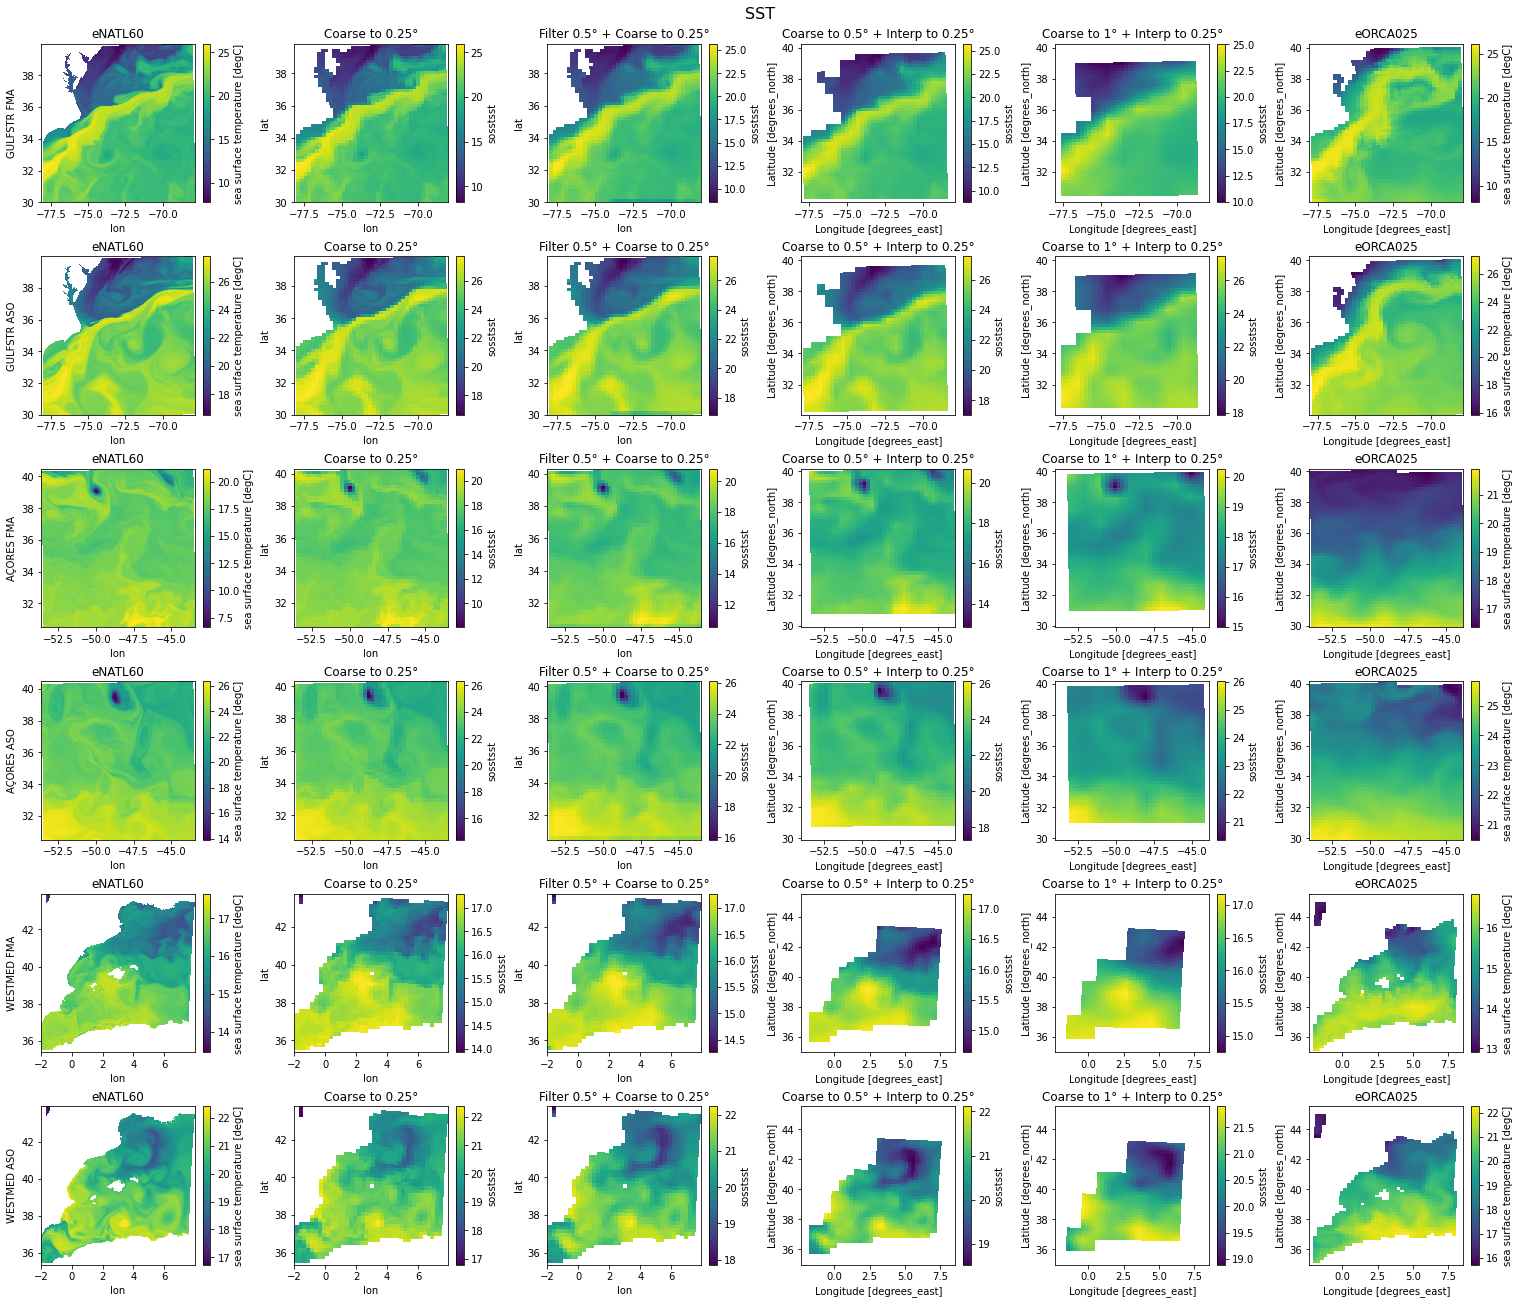

In [24]:
ncols = len(filters)+2 
nrows=len(data)
fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols,3*nrows), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('SST', size=16)
for row in range(len(data)) :
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='eNATL60')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1])
    axis[row,-1].set(title='eORCA025')    
    axis[row,0].set(ylabel=data[row]['label'])

# Subgrid temparature variance

In [25]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] :
        #ds['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, ds['sosaline'], ds['sosstsst'], dask='parallelized').compute()
        # SGS temp variance
        ds['var_T'] = ds['CT_sqr'] - ds['CT']**2
        # density correction
        ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['CT'], dask='parallelized').compute()
        ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']

CPU times: user 746 ms, sys: 41.7 ms, total: 787 ms
Wall time: 1.56 s


In [26]:
x_slice = slice(0,-1)
y_slice = slice(2,-2)
bord_cut = dict(y=y_slice,x=x_slice) # to cut borders 

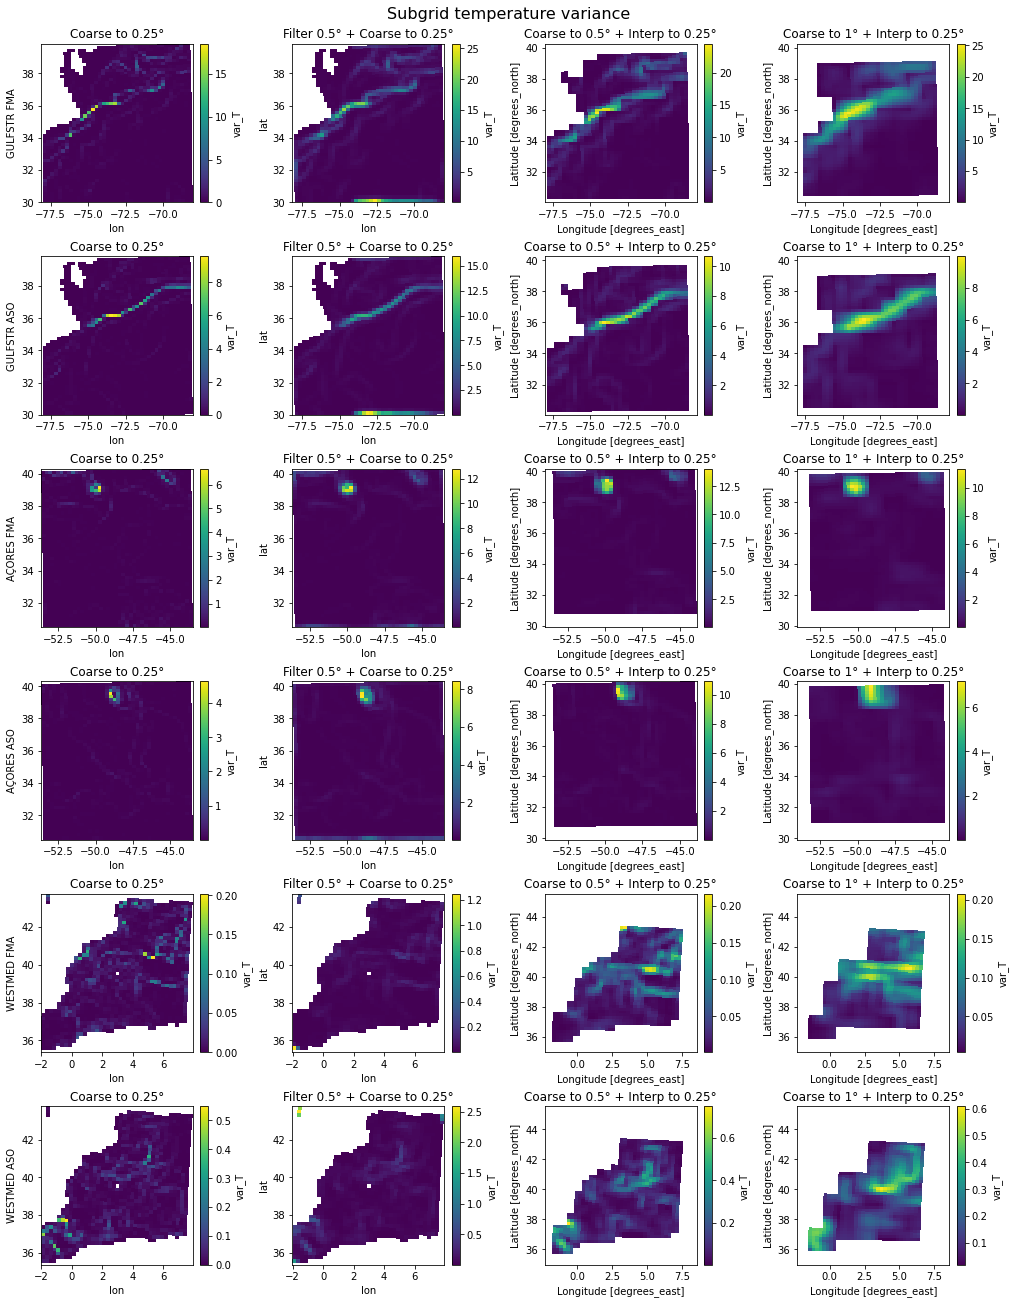

In [27]:
ncols = len(filters)
nrows=len(data)
fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols,3*nrows), constrained_layout=True)
quantity='var_T'
fig.suptitle('Subgrid temperature variance', size=16)
for row in range(len(data)) :
    for ifilter in range(len(filters)) :
        col = ifilter
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col], cmap='viridis')
        axis[row,col].set(title=filters[ifilter]['label'])   
    axis[row,0].set(ylabel=data[row]['label'])

# Deterministic parametrization for SGS variance of temperature

From (Stanley et al 2021):
$$ \rho_c = \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 $$
$$ \sigma_T^2 \approx \mathscr{s}_T^2 \equiv c |\delta \textbf{x} \cdot \nabla \bar{T}|^2 $$ 
where the coefficient $c$ can depend on the resolution. The theoretcal estimate is $c=1/12$. The values found from fitting of the data is $c=0.2$.

In [28]:
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [29]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['CT'])
        ds["diff_T_sqr"] = central_diffs_x(ds['CT'])**2 + central_diffs_y(ds['CT'])**2
        ds["diff_T_sqr_dens_deriv"] = ds['rho_ct_ct']*ds["diff_T_sqr"]
        ds["diff_S_sqr"] = central_diffs_x(ds['sosaline'])**2 + central_diffs_y(ds['sosaline'])**2
        ds["diff_S_sqr_dens_deriv"] = ds['rho_sa_sa']*ds["diff_S_sqr"]
        ds["diff_T_S_dens_deriv"] = ds['rho_sa_ct']*np.sqrt(ds["diff_T_sqr"])*np.sqrt(ds["diff_S_sqr"])
        ds["total_diff_dens_deriv"] = ds["diff_T_sqr_dens_deriv"] + 2.0*ds["diff_T_S_dens_deriv"] + ds["diff_S_sqr_dens_deriv"]

CPU times: user 35.7 s, sys: 419 ms, total: 36.1 s
Wall time: 36.1 s


# Histograms of true SGS variance $\sigma_T^2$ and its parametrization

In [44]:
%%time
name_hist = 'hist_var_T'
x = 'diff_T_sqr'
y = 'var_T'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case], x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter], x, y, nb_of_bins, bins=bins).compute()
        [hists[i]['HR_Filtered'][ifilter][name_hist].attrs['slope'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['increment'], \
         hists[i]['HR_Filtered'][ifilter][name_hist].attrs['residuals'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_x'], hists[i]['HR_Filtered'][ifilter][name_hist].attrs['mean_y']] = \
        fit_2D_histogram(hists[i]['HR_Filtered'][ifilter][name_hist])

CPU times: user 1.83 s, sys: 66.6 ms, total: 1.9 s
Wall time: 6.51 s


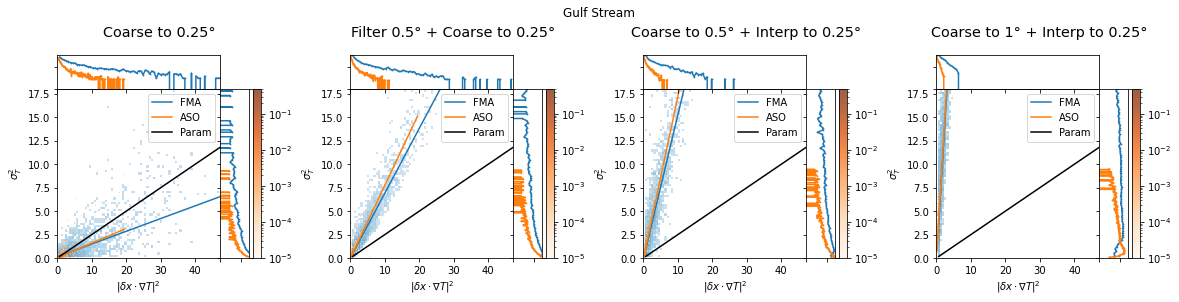

In [45]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Gulf Stream')
name_hist = 'hist_var_T'
x = 'diff_T_sqr'
y = 'var_T'
region=0
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.25*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$|\delta x \cdot \nabla T|^2$', ylabel=r'$\sigma_T^2$', xscale='linear', yscale='linear')
    big_ax.legend(handles=big_ax.lines, labels=['FMA', 'ASO', 'Param'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

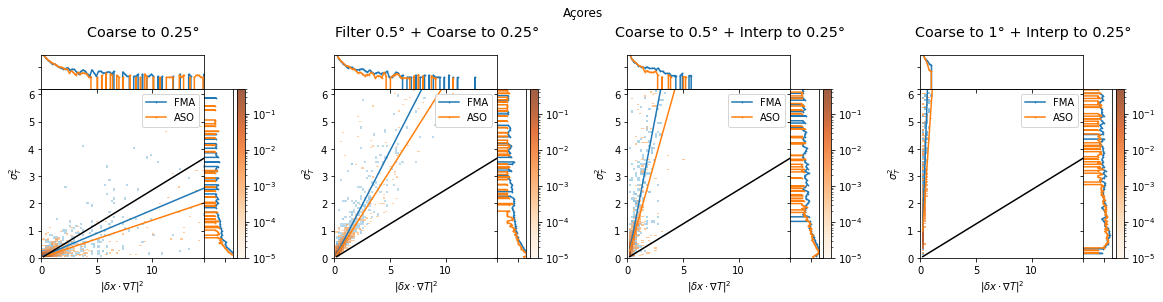

In [46]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Açores')
name_hist = 'hist_var_T'
x = 'diff_T_sqr'
y = 'var_T'
region=2
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    big_ax.plot(x_points, 0.25*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$|\delta x \cdot \nabla T|^2$', ylabel=r'$\sigma_T^2$')
    big_ax.legend(handles=top_ax.lines, labels=['FMA', 'ASO'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

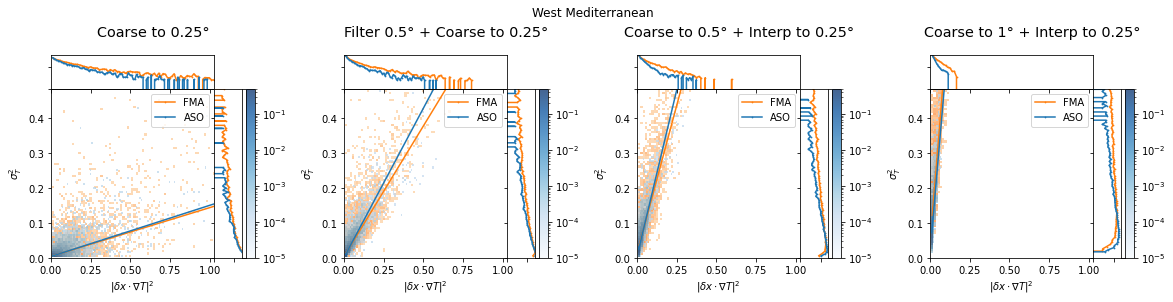

In [47]:
fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(16, 4))
fig.suptitle('West Mediterranean')
name_hist = 'hist_var_T'
x = 'diff_T_sqr'
y = 'var_T'
region=4
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 4, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for i in range(len(filters)) :
    subfigs[i].suptitle(filters[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    hist_joint = margin_hist(hists[region+1]['HR_Filtered'][i][name_hist], 1, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)    
    hist_joint = margin_hist(hists[region]['HR_Filtered'][i][name_hist], 0, x+'_bin', y+'_bin', top_ax, right_ax, big_ax)
    x_points = hists[region+1]['HR_Filtered'][ifilter][name_hist][x+'_bin']
    #big_ax.plot(x_points, 0.25*x_points, 'k', label='Param')
    big_ax.set(xlabel=r'$|\delta x \cdot \nabla T|^2$', ylabel=r'$\sigma_T^2$')
    big_ax.legend(handles=top_ax.lines, labels=['FMA', 'ASO'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[region+1]['HR_Filtered'][i][name_hist][x+'_bin'].max()],\
              ylim=[0,0.5*hists[region+1]['HR_Filtered'][i][name_hist][y+'_bin'].max()])
    subfigs[i].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)
plt.show()

## Slopes and SD for temperature variance parametrization

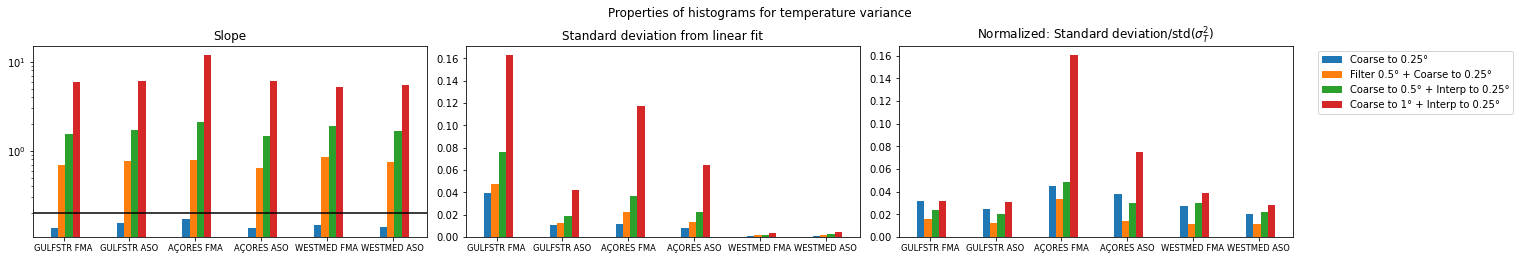

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(21, 3.5))
fig.suptitle('Properties of histograms for temperature variance')
name_hist = 'hist_var_T'
x = np.arange(6)
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax[0].bar(x+ifilter*bar_width, [hists[region]['HR_Filtered'][ifilter][name_hist].attrs['slope'] for region in range(len(data))], width=bar_width)
    ax[1].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals']) \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
    ax[2].bar(x+ifilter*bar_width, [np.sqrt(hists[region]['HR_Filtered'][ifilter][name_hist].attrs['residuals'])/data[region]['HR_Filtered'][ifilter]['var_T'].std() \
                                    for region in range(len(data))], width=bar_width, label=filters[ifilter]['label'])
for axis in ax :
    axis.set_xticks(x + 1.25*bar_width)
    axis.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
    axis.xaxis.set_tick_params(labelsize='small')
    
ax[0].axhline(y=0.2, color='k')
ax[0].set(title='Slope')
ax[0].set(yscale='log')
    
ax[1].set(title=r'Standard deviation from linear fit')
ax[1].set(yscale='linear')

ax[2].set(title=r'Normalized: Standard deviation/std($\sigma_T^2$)')
ax[2].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Histograms of the predictors for density correction

In [34]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'eNATL60'})
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

## Plot 2D histogram

In [35]:
%%time
name_hist = 'hist_pred'
x='diff_T_sqr_dens_deriv'
y='diff_S_sqr_dens_deriv'

for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['HR_Filtered'][ref_case], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['HR','LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter], x, y, nb_of_bins, bins=bins).compute()

CPU times: user 6.46 s, sys: 525 ms, total: 6.99 s
Wall time: 20 s


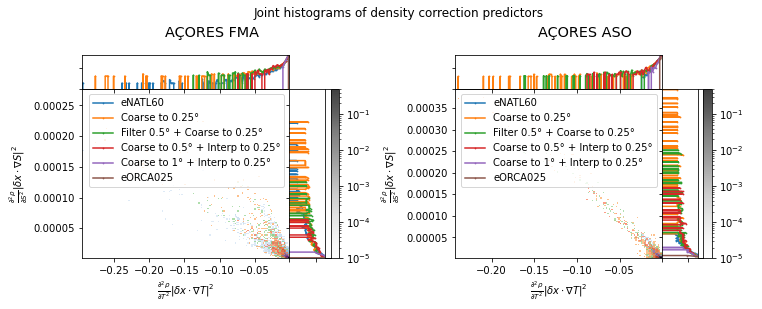

In [36]:
name_hist = 'hist_pred'
x = 'diff_T_sqr_dens_deriv_bin'
y = 'diff_S_sqr_dens_deriv_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('Joint histograms of density correction predictors')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([2,3]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    labels_list = [dict() for i in range(2+len(filters))]
    for ihist, curr_histogram in enumerate([hists[region]['HR']] + [hists[region]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [hists[region]['LR']]) :
        hist_joint = margin_hist(curr_histogram[name_hist], ihist, x, y, top_ax, right_ax, big_ax)
        labels_list[ihist] = curr_histogram['label']
    big_ax.set(xlabel=r'$\frac{\partial^2 \rho}{\partial T^2} |\delta x \cdot \nabla T|^2$', ylabel=r'$\frac{\partial^2 \rho}{\partial S^2} |\delta x \cdot \nabla S|^2$')
    big_ax.legend(handles=top_ax.lines, labels=labels_list, loc='upper right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

## Distance between histograms

- Bhattacharyya distance (to estimate overlap between two distributions):
$$ D_B(P,Q) = -\log[BC(P,Q)] $$
$$ BC(P,Q) = \sum_i \sqrt{P(i) Q(i)} $$
- Helliger distance:
$$D_H (P,Q) = \sqrt{1-BC(P,Q)}$$ 
is limited $0<D_H (P,Q)<1$ 

In [103]:
def BC(hist_P, hist_Q) :
    return np.nansum(np.sqrt(hist_P*hist_Q))

def D_H(hist_P, hist_Q) :
    return np.sqrt(1.-np.around(BC(hist_P,hist_Q), decimals=5))

def D_B(hist_P, hist_Q) :
    BC_val = BC(hist_P,hist_Q)
    if (BC_val > 0) :
        return -np.log(BC_val)
    else:
        return np.NaN

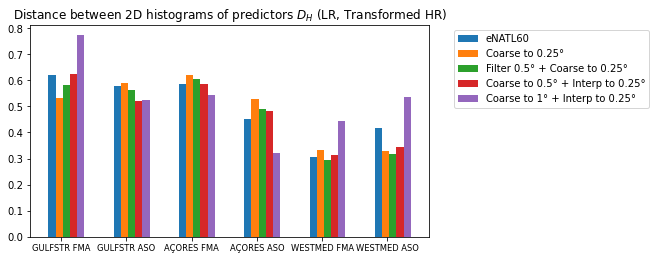

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(9, 3.5))
name_hist = 'hist_pred'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
ax.bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='eNATL60')
for ifilter in range(len(filters)) :
    ax.bar(x+(ifilter+1)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
ax.set_xticks(x + 1.25*bar_width)
ax.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax.xaxis.set_tick_params(labelsize='small')
ax.set(title=r'Distance between 2D histograms of predictors $D_H$ ('+ ref_dataKey +', Transformed HR)')
ax.set(yscale='linear')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Applying density parametrization to eORCA025 and filtered fields

From (Stanley et al 2021):
$$ \rho_c = \frac{1}{2} \frac{\partial^2 \rho (\bar{T}, \bar{S})}{\partial \bar{T}^2} \sigma_T^2 $$
$$ \sigma_T^2 \approx \mathscr{s}_T^2 \equiv c |\delta \textbf{x} \cdot \nabla \bar{T}|^2 $$ 
where the coefficient $c$ can depend on the resolution. The theoretcal estimate is $c=1/12$. The values found from fitting of the data is $c=0.2$.

In [50]:
c=0.2

In [55]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds['param_sigma0_delta'] = 0.5*c*ds["diff_T_sqr_dens_deriv"]

CPU times: user 119 ms, sys: 2.1 ms, total: 121 ms
Wall time: 119 ms


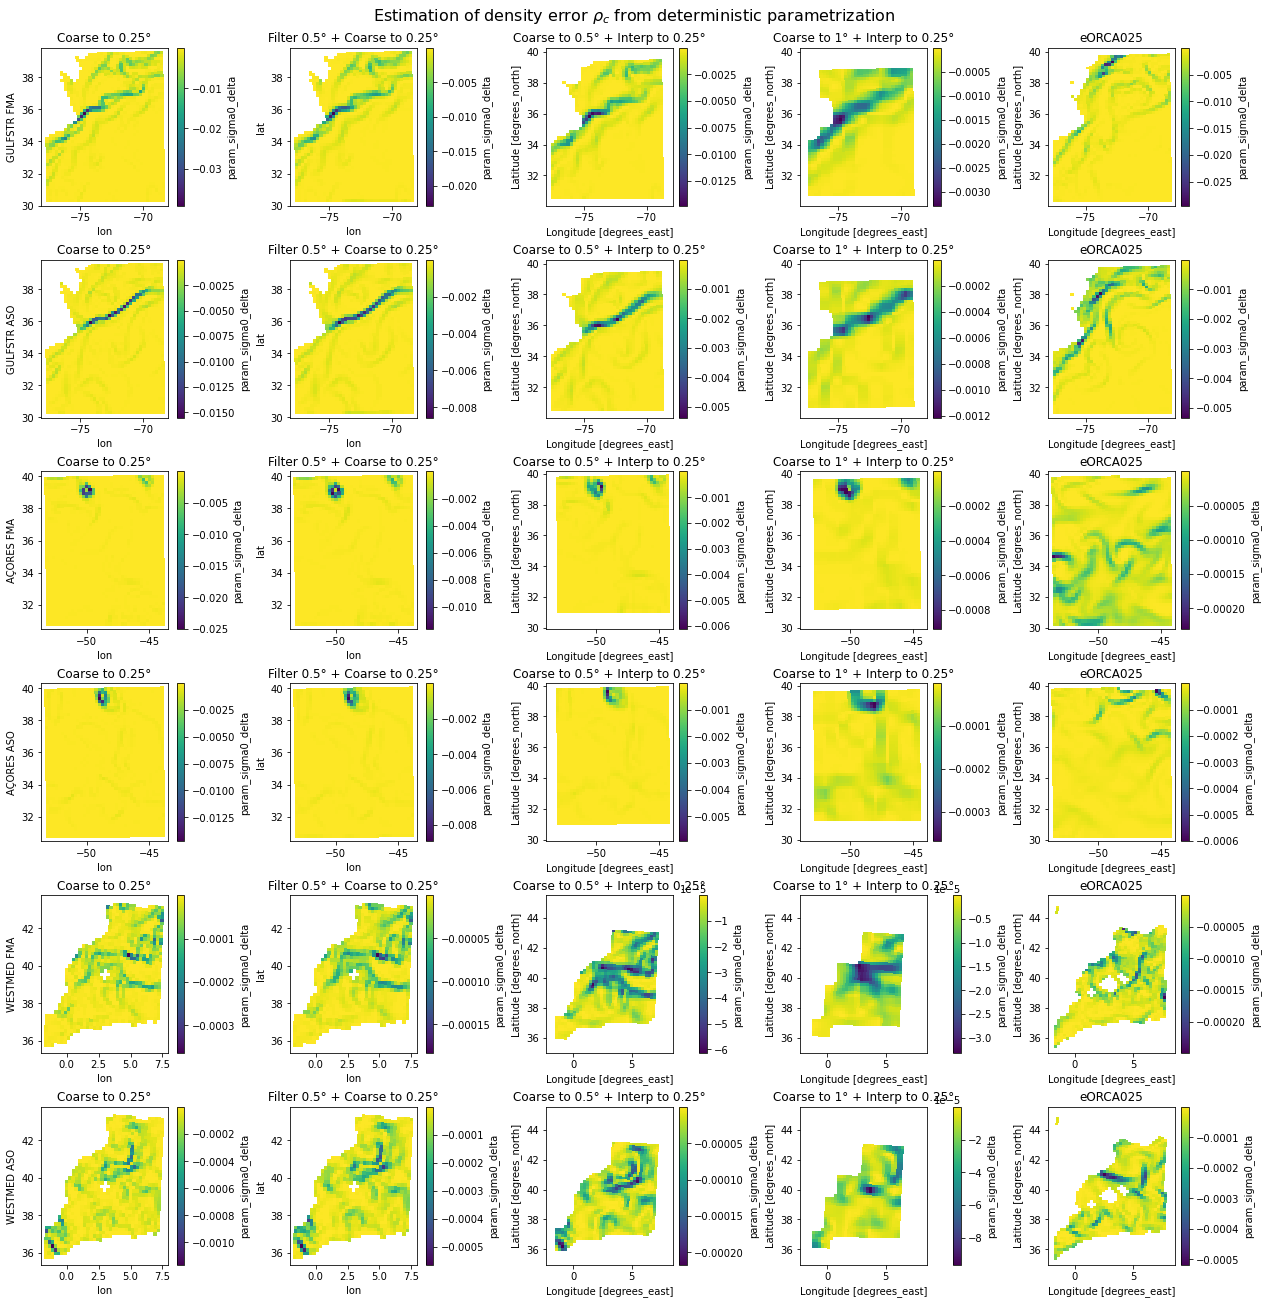

In [62]:
ncols = len(filters)+1
nrows=len(data)
fig, axis = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols,3*nrows), constrained_layout=True)
quantity='param_sigma0_delta'
fig.suptitle(r'Estimation of density error $\rho_c$ from deterministic parametrization', size=16)
for row in range(len(data)) :
    for ifilter in range(len(filters)) :
        col = ifilter
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1])
    axis[row,-1].set(title='eORCA025')    
    axis[row,0].set(ylabel=data[row]['label'])

## Histograms

In [118]:
%%time
for i in range(len(data)) :
    # reference histogram
    ref_histo = compute_1D_histogram(data[i]['HR_Filtered'][3], 'param_sigma0_delta', nb_of_bins, bins=None).compute()
    ref_bins = ref_histo['param_sigma0_delta_bin'].values
    
    hists[i]['LR']['param_sigma0_delta'] = compute_1D_histogram(data[i]['LR'], 'param_sigma0_delta', nb_of_bins, bins=ref_bins).compute()
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter]['param_sigma0_delta'] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter], 'param_sigma0_delta', nb_of_bins, bins=ref_bins)

CPU times: user 2.07 s, sys: 57.5 ms, total: 2.13 s
Wall time: 5.28 s


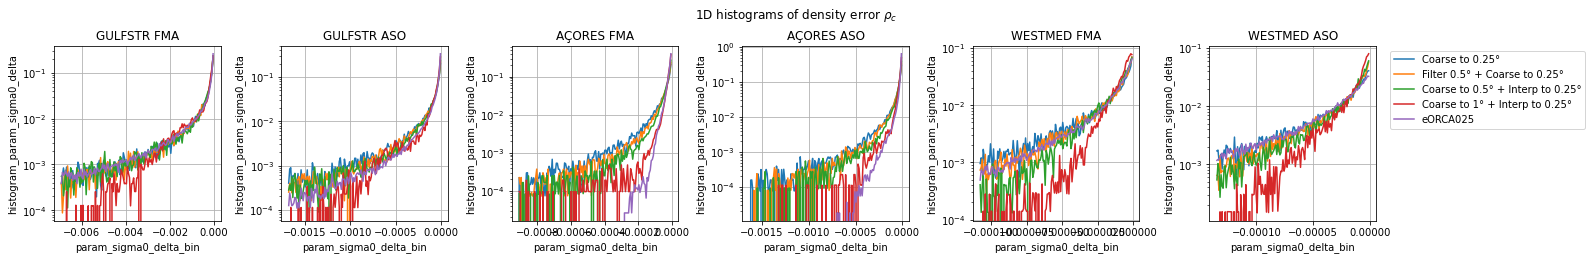

In [119]:
histo_name='param_sigma0_delta'

fig, ax = plt.subplots(nrows=1, ncols=6, constrained_layout=True, figsize=(22, 3.5))
fig.suptitle(r'1D histograms of density error $\rho_c$')
for i in range(len(data)) :
    for ds in [hists[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [hists[i]['LR']] :
        ds[histo_name].plot(ax=ax[i], label=ds['label'])
    ax[i].set(title=data[i]['label'], yscale='log'); ax[i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

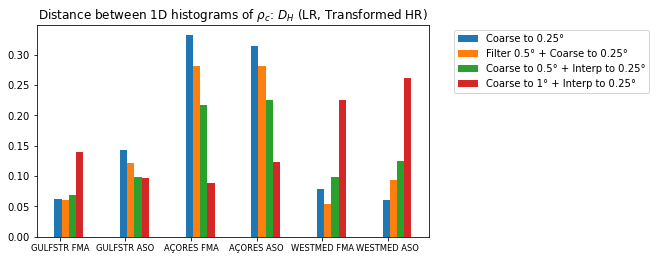

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(9, 3.5))
name_hist = 'param_sigma0_delta'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
for ifilter in range(len(filters)) :
    ax.bar(x+(ifilter+1)*bar_width, [D_H(hists[region]['LR'][name_hist], hists[region]['HR_Filtered'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
ax.set_xticks(x + 1.25*bar_width)
ax.set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax.xaxis.set_tick_params(labelsize='small')
ax.set(title=r'Distance between 1D histograms of $\rho_c$: $D_H$ ('+ ref_dataKey +', Transformed HR)')
ax.set(yscale='linear')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()